# RSRAE

https://github.com/marrrcin/rsrlayer-pytorch

https://arxiv.org/abs/1904.00152

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
from random import sample

from typing import List

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

%matplotlib inline

In [2]:
data = pd.read_csv('./data/orphos.txt', sep=';')
data.head()

CORRECT  MISTAKE  WEIGHT
0  болото   болотл  0.3333
1  болото  болотао  0.2500
2  болото   балото  0.1219
3  болото    болто  0.0562
4  болото  болотаъ  0.0526

In [3]:
data.shape

(85550, 3)

In [4]:
correct_words = data['CORRECT'].unique().tolist()
len(correct_words)

21749

In [5]:
correct_words = list(filter(lambda x: len(x) >= 4, correct_words))
len(correct_words)

21008

In [6]:
data['CORRECT'].apply(len).value_counts()

CORRECT
6     13610
7     13423
5     11652
4     10749
8      9727
3      7632
9      6836
10     4507
11     2938
12     1783
13     1067
14      559
1       336
15      255
2       250
16      120
17       54
18       38
19        7
21        6
20        1
Name: count, dtype: int64

In [7]:
correct_df = data[['CORRECT']].copy()
mistake_df = data[['MISTAKE']].copy().sample(frac=0.1).reset_index(drop=True) # only 10%

correct_df['is_error'] = 0
mistake_df['is_error'] = 1

correct_df.rename({'CORRECT': 'word'}, axis=1, inplace=True)
mistake_df.rename({'MISTAKE': 'word'}, axis=1, inplace=True)

df = pd.concat([correct_df, mistake_df], axis=0, ignore_index=True)

In [8]:
df['is_error'].value_counts()

is_error
0    85550
1     8555
Name: count, dtype: int64

In [9]:
df = df.sample(frac=1).reset_index(drop=True) # random shuffle

In [10]:
BOS, EOS = '_BOS_', '_EOS_'
generated_dataset = df['word'].tolist()

lines = [[BOS] + list(line) + [EOS] for line in generated_dataset]

lines[:3]

[['_BOS_', 'м', 'з', 'д', 'а', '_EOS_'],
 ['_BOS_', 'б', 'е', 'з', 'д', 'е', 'н', 'е', 'ж', 'ь', 'е', '_EOS_'],
 ['_BOS_', 'з', 'д', 'а', 'ч', 'а', '_EOS_']]

In [11]:
tokens = []
for text in lines:
    tokens.extend(text)
tokens = list(set(tokens))

In [12]:
tokens = sorted(tokens)
n_tokens = len(tokens)
print('n_tokens =', n_tokens)
token_to_id = {token: id for id, token in enumerate(tokens)}
token_to_id

n_tokens = 36


{'-': 0,
 '_BOS_': 1,
 '_EOS_': 2,
 'а': 3,
 'б': 4,
 'в': 5,
 'г': 6,
 'д': 7,
 'е': 8,
 'ж': 9,
 'з': 10,
 'и': 11,
 'й': 12,
 'к': 13,
 'л': 14,
 'м': 15,
 'н': 16,
 'о': 17,
 'п': 18,
 'р': 19,
 'с': 20,
 'т': 21,
 'у': 22,
 'ф': 23,
 'х': 24,
 'ц': 25,
 'ч': 26,
 'ш': 27,
 'щ': 28,
 'ъ': 29,
 'ы': 30,
 'ь': 31,
 'э': 32,
 'ю': 33,
 'я': 34,
 'ё': 35}

In [13]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

dummy_lines = [
    'абв',
    'абвгде',
    'абвгдезжы',
]
print(to_matrix(dummy_lines))

[[ 3  4  5  2  2  2  2  2  2]
 [ 3  4  5  6  7  8  2  2  2]
 [ 3  4  5  6  7  8 10  9 30]]


# RSRAE

In [14]:
class Encoder(nn.Module):
    def __init__(self, inp_voc: dict, hid_size: int, D: int, EOS=EOS):
        super().__init__()
        n_tokens = len(inp_voc)
        self.inp_voc = inp_voc
        self.eos = inp_voc[EOS]

        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size, device=device)
        self.rnn1 = nn.LSTM(input_size=hid_size, hidden_size=hid_size//2, num_layers=1, batch_first=True, device=device)
        self.rnn2 = nn.LSTM(input_size=hid_size//2, hidden_size=D, num_layers=1, batch_first=True, device=device)

    def __call__(self, input_ix):
        input_ix = input_ix.to(device)
        x = self.emb(input_ix)

        output, _ = self.rnn1(x)
        
        output, _ = self.rnn2(output)
        lengths = (input_ix != self.eos).to(torch.int64).sum(dim=1).clamp_max(input_ix.shape[1]-1)
        last_state = output[torch.arange(len(output)), lengths]

        return last_state

In [15]:
class RSRLayer(nn.Module):
    def __init__(self, d: int, D: int):
        super().__init__()
        self.d = d
        self.D = D
        self.A = nn.Parameter(torch.nn.init.orthogonal_(torch.empty(d, D)))

    def forward(self, z):
        z_hat = self.A @ z.view(z.size(0), self.D, 1)
        return z_hat.squeeze(2)

In [16]:
class Decoder(nn.Module):
    def __init__(self, n_tokens: int, d: int, hid_size: int):
        super().__init__()

        self.rnn1 = nn.LSTM(input_size=d, hidden_size=hid_size//2, num_layers=1, batch_first=True, device=device)
        self.rnn2 = nn.LSTM(input_size=hid_size//2, hidden_size=hid_size, num_layers=1, batch_first=True, device=device)

        self.classifier = nn.Linear(hid_size, n_tokens)

    def __call__(self, encoded_inp, seq_len):
        x = encoded_inp.to(device)
        batch_size, enc_dim = x.shape

        x = x.repeat(seq_len, 1, 1).permute(1, 0, 2)

        output, _ = self.rnn1(x)
        
        output, _ = self.rnn2(output)
        output = self.classifier(output)
        
        return output

In [17]:
class Autoencoder(nn.Module):
    def __init__(self, tokens: List, inp_voc: dict, hid_size: int=128, D: int=64, d: int=16):
        super().__init__()

        self.tokens = tokens
        n_tokens = len(tokens)

        self.encoder = Encoder(inp_voc, hid_size, D)
        self.rsr = RSRLayer(d, D)
        self.decoder = Decoder(n_tokens, d, hid_size)

        self._init_weights()

    def __call__(self, input_ix):
        x = input_ix.to(device)
        seq_len = x.shape[1]

        enc = self.encoder(x)
        latent = self.rsr(enc)
        dec = self.decoder(latent, seq_len)
        
        return enc, dec, latent, self.rsr.A

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)

    def get_tokens_probs(self, input_ix):
        prefix_ix = torch.as_tensor(to_matrix([input_ix]), dtype=torch.int64, device=device)
        result_probs = []
        with torch.no_grad():
            enc, dec, latent, A = self(prefix_ix)
            probs = torch.softmax(dec, dim=-1).cpu().numpy()
            for idx in list(zip(range(len(input_ix)), prefix_ix[0])):
                result_probs.append(probs[0][idx])
        return result_probs, list(zip(input_ix, result_probs))

In [18]:
class RSRLoss(nn.Module):
    def __init__(self, lambda1: int, lambda2: int, d: int, D: int):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.d = d
        self.D = D
        self.register_buffer(
            "Id", torch.eye(d)
        )

    def forward(self, z, A):
        z_hat = A @ z.view(z.size(0), self.D, 1)
        AtAz = (A.T @ z_hat).squeeze(2)
        term1 = torch.sum(
            torch.norm(z - AtAz, p=2)
        )

        term2 = torch.norm(
            A @ A.T - self.Id, p=2
        ) ** 2

        return self.lambda1 * term1 + self.lambda2 * term2

In [19]:
class ReconstructionLoss(nn.Module):
    def forward(self, input_logits, input_ix):

        mask = self.compute_mask(input_ix)
        loss = torch.mean(torch.gather(logits, dim=2, index=input_ix[:, :, None])[mask])

        return loss

    def compute_mask(self, input_ix, eos_ix=token_to_id[EOS]):
        """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
        return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [66]:
from sklearn.model_selection import train_test_split
train_lines, val_lines = train_test_split(lines, test_size=0.25, random_state=seed)

batch_size = 128
score_val_every = 1000

hid_size = 128
d = 16
D = 32

train_history, val_history = [], []

model = Autoencoder(tokens=tokens, inp_voc=token_to_id, hid_size=hid_size, D=D, d=d)

reconctruction_loss = ReconstructionLoss().to(device)
rsr_loss = RSRLoss(1, 1, d, D).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

model.to(device)

Autoencoder(
  (encoder): Encoder(
    (emb): Embedding(36, 128)
    (rnn1): LSTM(128, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (rsr): RSRLayer()
  (decoder): Decoder(
    (rnn1): LSTM(16, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (classifier): Linear(in_features=128, out_features=36, bias=True)
  )
)

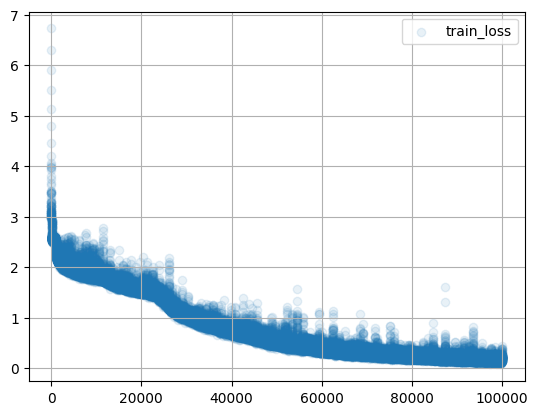

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:00:06<00:00, 27.73it/s]


In [67]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 100000):
    batch = to_matrix(sample(train_lines, batch_size))
    batch = torch.as_tensor(batch).to(device)

    enc, dec, latent, A = model(batch)
    logits = -F.log_softmax(dec, -1)

    rec_loss_i = reconctruction_loss(logits, batch)
    rsr_loss_i = rsr_loss(enc, A)
    
    loss_i = rec_loss_i + rsr_loss_i
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(val_history):
            plt.plot(*zip(*val_history), color='red', label='val_loss')
        plt.legend(); plt.grid(); plt.show()
    
    # if (i + 1) % score_val_every == 0:
    #     print("Scoring val...")
    #     val_history.append((i, score_lines(model, val_lines, batch_size)))
    #     print('#%i Val loss: %.3f' % val_history[-1])

In [68]:
torch.save(model.state_dict(), './autoencoder.pth')
model.load_state_dict(torch.load('./autoencoder.pth'))

device = 'cpu'

model.to(device)
model.eval()

Autoencoder(
  (encoder): Encoder(
    (emb): Embedding(36, 128)
    (rnn1): LSTM(128, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (rsr): RSRLayer()
  (decoder): Decoder(
    (rnn1): LSTM(16, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (classifier): Linear(in_features=128, out_features=36, bias=True)
  )
)

In [69]:
model.get_tokens_probs(lines[0])

([1.0, 0.97089326, 0.92085695, 0.99970067, 0.9999949, 1.0],
 [('_BOS_', 1.0),
  ('м', 0.97089326),
  ('з', 0.92085695),
  ('д', 0.99970067),
  ('а', 0.9999949),
  ('_EOS_', 1.0)])

In [70]:
id_to_token = {value: key for key, value in token_to_id.items()}

In [71]:
def perplexity(model, line, min_logprob=np.log(10**-50.)):
    N = len(line)

    clear_probs, _ = model.get_tokens_probs(line)
    clear_probs = np.maximum(np.log(clear_probs), min_logprob)

    log_prob = np.sum(clear_probs)

    return np.exp(-log_prob / N)

In [72]:
perplexity(model, lines[0])

1.0188918727026723

In [73]:
frame = df.copy()
frame.head()

word  is_error
0          мзда         0
1    безденежье         0
2         здача         1
3       радости         0
4  близорукость         0

In [74]:
frame['tokenized'] = lines

In [75]:
%%time

frame['perplexity'] = frame['tokenized'].apply(lambda x: perplexity(model, x))

CPU times: total: 10min 31s
Wall time: 1min 45s


In [76]:
frame.sort_values('perplexity', ascending=False)[:20]

word  is_error  \
3208            теаьтр         1   
30483         главнаый         1   
14041       лесотундра         0   
66514              вге         1   
32048     сперматозоид         0   
30515               чо         1   
27049            узелк         1   
23869              цна         1   
73510         пугливыу         1   
87808     способностьб         1   
20072         счастьеэ         1   
63543             эьфы         1   
45088         оимпиада         1   
77171  старшеклассница         0   
34358    юго-восточный         0   
48021             аооа         1   
24763               оь         1   
88876       красноярск         0   
46391         взыскать         0   
78309   диеспособность         1   

                                               tokenized  perplexity  
3208                    [_BOS_, т, е, а, ь, т, р, _EOS_]   67.662356  
30483             [_BOS_, г, л, а, в, н, а, ы, й, _EOS_]   56.096920  
14041       [_BOS_, л, е, с, о, т, у, н, д, р, а, _EOS_]   43.513170  
66514                            [_BOS_, в, г, е, _EOS_]   39.202857  
32048  [_BOS_, с, п, е, р, м, а, т, о, з, о, и, д, _E...   34.570403  
30515                               [_BOS_, ч, о, _EOS_]   30.763338  
27049                      [_BOS_, у, з, е, л, к, _EOS_]   29.811150  
23869                            [_BOS_, ц, н, а, _EOS_]   29.039476  
73510             [_BOS_, п, у, г, л, и, в, ы, у, _EOS_]   25.980691  
87808  [_BOS_, с, п, о, с, о, б, н, о, с, т, ь, б, _E...   25.702942  
20072             [_BOS_, с, ч, а, с, т, ь, е, э, _EOS_]   24.994957  
63543                         [_BOS_, э, ь, ф, ы, _EOS_]   23.188432  
45088             [_BOS_, о, и, м, п, и, а, д, а, _EOS_]   23.178880  
77171  [_BOS_, с, т, а, р, ш, е, к, л, а, с, с, н, и,...   23.139616  
34358  [_BOS_, ю, г, о, -, в, о, с, т, о, ч, н, ы, й,...   23.071548  
48021                         [_BOS_, а, о, о, а, _EOS_]   22.972328  
24763                               [_BOS_, о, ь, _EOS_]   21.098536  
88876       [_BOS_, к, р, а, с, н, о, я, р, с, к, _EOS_]   20.708810  
46391             [_BOS_, в, з, ы, с, к, а, т, ь, _EOS_]   20.489718  
78309  [_BOS_, д, и, е, с, п, о, с, о, б, н, о, с, т,...   20.194421

<Axes: >

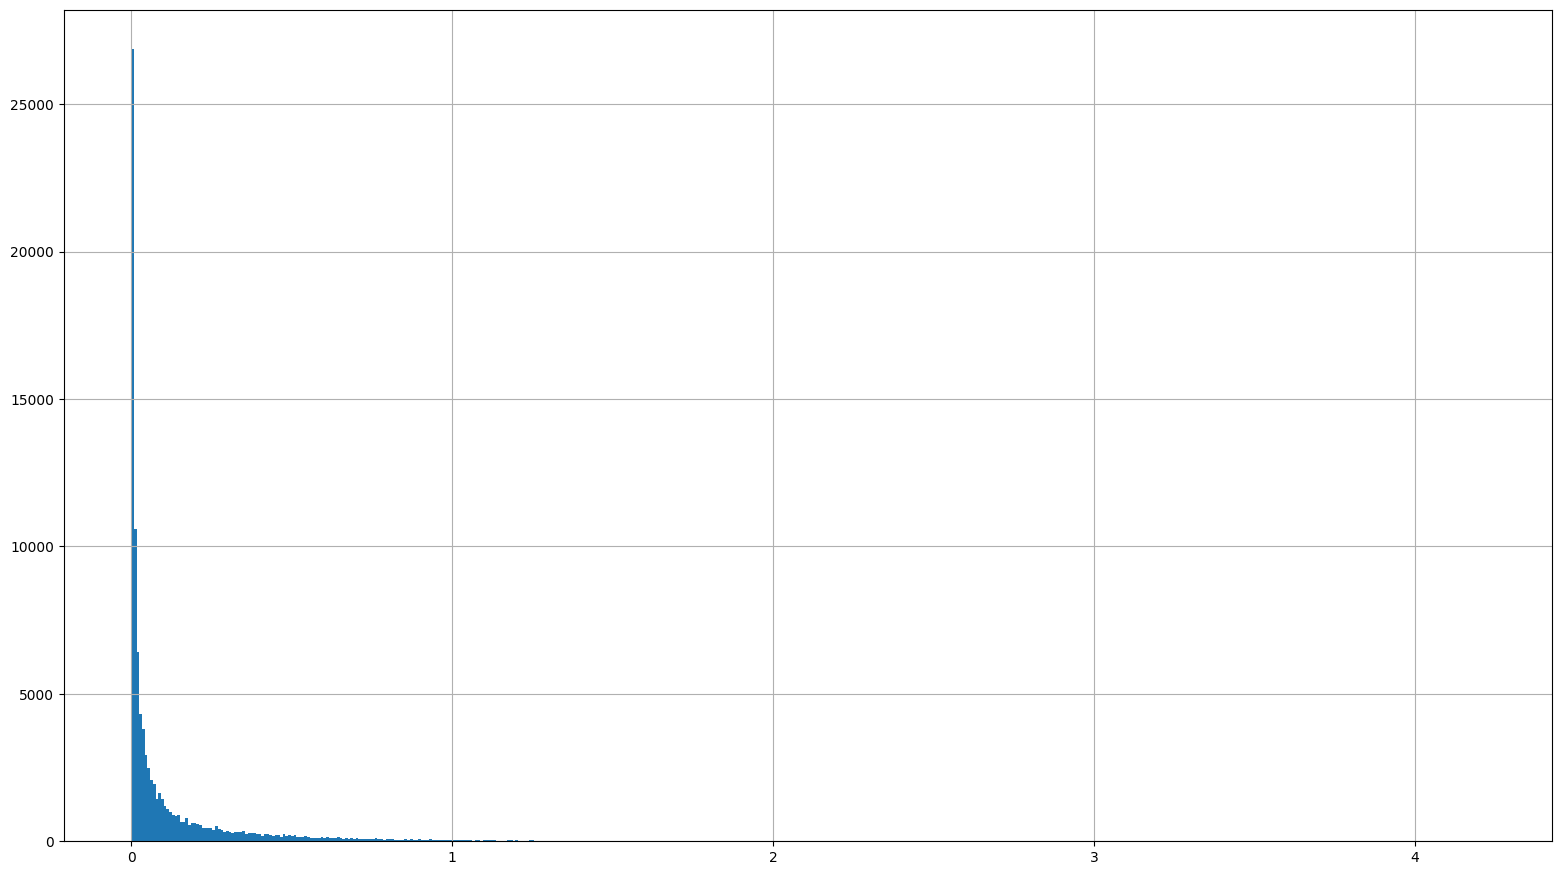

In [77]:
np.log(frame['perplexity']).hist(bins=500, figsize=(19.20, 10.80))

In [78]:
threshold = 1.0
frame['anomaly'] = 0

frame.loc[np.log(frame['perplexity']) > threshold, 'anomaly'] = 1
frame.sample(5)

word  is_error                                        tokenized  \
25417  непонимание         0  [_BOS_, н, е, п, о, н, и, м, а, н, и, е, _EOS_]   
35476       погреб         0                 [_BOS_, п, о, г, р, е, б, _EOS_]   
36295      обложка         0              [_BOS_, о, б, л, о, ж, к, а, _EOS_]   
80040       чесать         0                 [_BOS_, ч, е, с, а, т, ь, _EOS_]   
54674        отток         0                    [_BOS_, о, т, т, о, к, _EOS_]   

       perplexity  anomaly  
25417    1.207912        0  
35476    1.008516        0  
36295    1.008895        0  
80040    1.047889        0  
54674    1.228566        0

In [79]:
from sklearn.metrics import classification_report
print(classification_report(frame['is_error'], frame['anomaly']))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     85550
           1       0.37      0.08      0.14      8555

    accuracy                           0.90     94105
   macro avg       0.64      0.53      0.54     94105
weighted avg       0.86      0.90      0.88     94105



In [80]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral5
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    if isinstance(color, pd.Series):
        colors = factor_cmap('color', palette=Spectral5, factors=color.unique()) 

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    if isinstance(color, pd.Series):
        fig.scatter('x', 'y', size=radius, color=colors, alpha=alpha, source=data_source)
    else:
        fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

In [81]:
def chunker(data, seq_len):
    return [data[i:i+seq_len] for i in range(0, len(data), seq_len)]

In [82]:
encs = []
latents = []

for data in chunker(lines, 32):
    with torch.no_grad():
        batch = to_matrix(data)
        batch = torch.as_tensor(batch).to(device)
        
        enc, dec, latent, A = model(batch)
        
    encs.append(enc.detach().numpy())
    latents.append(latent.detach().numpy())

encs = np.concatenate(encs, axis=0)
latents = np.concatenate(latents, axis=0)

In [83]:
# from sklearn.manifold import TSNE

# word_vectors = latents

# word_tsne = TSNE(n_components=2).fit_transform(word_vectors)
# word_tsne = (word_tsne - word_tsne.mean(axis=0)) / word_tsne.std(axis=0)

# word_tsne

In [84]:
# draw_vectors(word_tsne[:, 0], word_tsne[:, 1], token=list(map(lambda x: ''.join(x[1:-1]), train_lines)))

In [85]:
from sklearn.decomposition import PCA

word_vectors = latents

word_pca = PCA(n_components=2).fit_transform(word_vectors)
word_pca = (word_pca - word_pca.mean(axis=0)) / word_pca.std(axis=0)

In [86]:
draw_vectors(word_pca[:, 0], word_pca[:, 1], token=list(map(lambda x: ''.join(x[1:-1]), lines)), color=frame['is_error'].map({0: 'not_error', 1: 'error'}))

figure(id='p1051', ...)

In [87]:
normed_latents = latents / np.linalg.norm(latents, axis=1, keepdims=True)

In [117]:
topn = 5000
frame2 = frame.sort_values('perplexity', ascending=False)[:topn].copy()
frame2['closest_word'] = None
frame2['indexes'] = None

for i, row in frame2.iterrows():
    emb = normed_latents[i]
    distances = emb.dot(normed_latents.T)
    top1 = np.argsort(distances)[::-1][1]
    
    word1 = row['word']
    word2 = frame.iloc[top1]['word']

    frame2.loc[i, 'closest_word'] = word2

    max_len = max(map(len, [word1, word2]))
    word1 = np.array(list(word1.rjust(max_len)))
    word2 = np.array(list(word2.rjust(max_len)))

    frame2.loc[i, 'indexes'] = str(list(np.where(word1 != word2)[0]))

In [118]:
frame2

word  is_error  \
3208         теаьтр         1   
30483      главнаый         1   
14041    лесотундра         0   
66514           вге         1   
32048  сперматозоид         0   
...             ...       ...   
85026     шизофиник         1   
41475        иаузер         1   
74666      сюрпризы         0   
75755   расположить         0   
43890       этюдник         0   

                                               tokenized  perplexity  anomaly  \
3208                    [_BOS_, т, е, а, ь, т, р, _EOS_]   67.662356        1   
30483             [_BOS_, г, л, а, в, н, а, ы, й, _EOS_]   56.096920        1   
14041       [_BOS_, л, е, с, о, т, у, н, д, р, а, _EOS_]   43.513170        1   
66514                            [_BOS_, в, г, е, _EOS_]   39.202857        1   
32048  [_BOS_, с, п, е, р, м, а, т, о, з, о, и, д, _E...   34.570403        1   
...                                                  ...         ...      ...   
85026          [_BOS_, ш, и, з, о, ф, и, н, и, к, _EOS_]    1.887315        0   
41475                   [_BOS_, и, а, у, з, е, р, _EOS_]    1.887257        0   
74666             [_BOS_, с, ю, р, п, р, и, з, ы, _EOS_]    1.887212        0   
75755    [_BOS_, р, а, с, п, о, л, о, ж, и, т, ь, _EOS_]    1.886947        0   
43890                [_BOS_, э, т, ю, д, н, и, к, _EOS_]    1.886767        0   

        closest_word                                  indexes  
3208           ткант                       [0, 1, 2, 3, 4, 5]  
30483       обобщать                    [0, 1, 2, 3, 4, 6, 7]  
14041      непонятка              [0, 1, 2, 3, 4, 5, 6, 7, 8]  
66514           блек                             [0, 1, 2, 3]  
32048  психотерапевт  [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  
...              ...                                      ...  
85026      живортные                       [0, 2, 4, 5, 7, 8]  
41475         жаркое                          [0, 2, 3, 4, 5]  
74666       свхарики                          [1, 2, 3, 6, 7]  
75755   распределить              [0, 1, 2, 3, 4, 5, 6, 7, 8]  
43890        дижение                          [0, 1, 2, 3, 6]  

[5000 rows x 7 columns]

In [119]:
import io
from ast import literal_eval

def get_column_widths(reseted_table: pd.DataFrame, columns_list):
    columns_widths = {}
    for column in columns_list:
        columns_widths[column] = np.max([reseted_table[column].astype(str).apply(len).max(), len(column)])
    return columns_widths
    
def get_excel_formats(workbook) :
    col_format = workbook.add_format()
    col_format.set_align("center")
    col_format.set_border()
    
    index_str_format = workbook.add_format()
    index_str_format.set_align('left')
    index_str_format.set_bold(True)
    index_str_format.set_border()
    
    header_format = workbook.add_format({
        'fg_color': '#CCBF05', 'bold': True, 'border': True, 'align': 'center'
    })
    
    selection_format = workbook.add_format()
    selection_format.set_font_color('red')
    selection_format.set_bold(True)
    return col_format, index_str_format, header_format, selection_format
    
def format_xlsx_page(writer, table):
    columns = ["word", "perplexity", "closest_word", "indexes"]
    
    columns_widths = get_column_widths(table, columns)
    
    workbook = writer.book
    worksheet = writer.sheets['Сравнение']
    
    col_format, index_str_format, header_format, selection_format = get_excel_formats(workbook)
    
    for i, col in enumerate(columns):
        worksheet.set_column(i+1, i+1, columns_widths[col]+2, col_format)
        worksheet.write(0, i+1, str(col), header_format)
        
        if col == "word":
            for j in range(len(table)):
                string = str(table.loc[j, "word"])
                idxs = table.loc[j, 'indexes']
                if isinstance(idxs, str):
                    idxs = literal_eval(idxs)
                
                string_parts = []
                for let_i, let in enumerate(string):
                    if let_i in idxs:
                        string_parts.extend([selection_format, let])
                    else:
                        string_parts.append(let)
                        
                if len(string_parts) == 0:
                    string_parts = [' ']
                    
                worksheet.write_rich_string(
                    j+1,
                    i+1,
                    *string_parts)

        if col == "closest_word":
            for j in range(len(table)):
                string = str(table.loc[j, "closest_word"])
                idxs = table.loc[j, 'indexes']
                if isinstance(idxs, str):
                    idxs = literal_eval(idxs)
                
                string_parts = []
                for let_i, let in enumerate(string):
                    if let_i in idxs:
                        string_parts.extend([selection_format, let])
                    else:
                        string_parts.append(let)
                        
                if len(string_parts) == 0:
                    string_parts = [' ']
                    
                worksheet.write_rich_string(
                    j+1,
                    i+1,
                    *string_parts)
                
def dataframe_from_records_to_buffer(df):
    writer = pd.ExcelWriter("Word comparison.xlsx", engine='xlsxwriter')
    df.to_excel(writer, sheet_name="Сравнение")
    
    if not df.empty:
        format_xlsx_page(writer, df)
        writer.close() # save() deprecated

In [120]:
dataframe_from_records_to_buffer(frame2[["word", "perplexity", "closest_word", "indexes"]].reset_index(drop=True))

D:\Dev\jupyter\projects\Data Science\venvs\venv_yandex_nlp\lib\site-packages\xlsxwriter\worksheet.py:1344: UserWarning: You must specify more than 2 format/fragments for rich strings. Ignoring input in write_rich_string().
  warn(
